# Skin Cancer Detection Using Conveluted Neural Networks 

## Insatallation and importing of datasets and packages

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install kagglehub numpy pandas matplotlib seaborn pillow scikit-learn tqdm scikit-image

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 1.3 MB/s eta 0:00:0000:0100:02m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 450.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 259.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 921.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.6 MB/s eta 0:00:00m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 521.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 800.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 1.2 MB/s eta 0:00:0000:0100:010m


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import kagglehub as kh

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

import cv2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Download dataset
path = kh.dataset_download("rauf41/skin-cancer-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1


## Data Exploration

In [ ]:
import os
files = os.listdir("/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1")
print(len(files))

2


In [ ]:
files[0:10]

['HAM10000_metadata.csv', 'Skin Cancer Dataset']

In [ ]:
metadata = pd.read_csv('/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/HAM10000_metadata.csv')

# Display the first 20 rows
print(metadata.head(20))

      lesion_id      image_id   dx dx_type   age     sex     localization
0   HAM_0000118  ISIC_0027419  bkl   histo  80.0    male            scalp
1   HAM_0000118  ISIC_0025030  bkl   histo  80.0    male            scalp
2   HAM_0002730  ISIC_0026769  bkl   histo  80.0    male            scalp
3   HAM_0002730  ISIC_0025661  bkl   histo  80.0    male            scalp
4   HAM_0001466  ISIC_0031633  bkl   histo  75.0    male              ear
5   HAM_0001466  ISIC_0027850  bkl   histo  75.0    male              ear
6   HAM_0002761  ISIC_0029176  bkl   histo  60.0    male             face
7   HAM_0002761  ISIC_0029068  bkl   histo  60.0    male             face
8   HAM_0005132  ISIC_0025837  bkl   histo  70.0  female             back
9   HAM_0005132  ISIC_0025209  bkl   histo  70.0  female             back
10  HAM_0001396  ISIC_0025276  bkl   histo  55.0  female            trunk
11  HAM_0004234  ISIC_0029396  bkl   histo  85.0  female            chest
12  HAM_0004234  ISIC_0025984  bkl   h

In [ ]:
# Display the last 20 rows
print(metadata.tail(20))

         lesion_id      image_id     dx dx_type   age     sex     localization
9995   HAM_0000193  ISIC_0027950  akiec   histo  60.0  female             face
9996   HAM_0006180  ISIC_0027615  akiec   histo  70.0    male  upper extremity
9997   HAM_0006180  ISIC_0028990  akiec   histo  70.0    male  upper extremity
9998   HAM_0004282  ISIC_0033358  akiec   histo  65.0  female             face
9999   HAM_0000356  ISIC_0030655  akiec   histo  60.0  female             face
10000  HAM_0004282  ISIC_0033151  akiec   histo  65.0  female             face
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female             face
10002  HAM_0006442  ISIC_0032947  akiec   histo  70.0    male             hand
10003  HAM_0004592  ISIC_0029141  akiec   histo  60.0  female             face
10004  HAM_0005579  ISIC_0029309  akiec   histo  80.0    male             face
10005  HAM_0005579  ISIC_0028393  akiec   histo  80.0    male             face
10006  HAM_0004034  ISIC_0024948  akiec   histo  55.

In [ ]:
unique_dx = metadata['dx'].unique()
unique_dx_type = metadata['dx_type'].unique()
unique_localization = metadata['localization'].unique()

# Print the unique values
print("Unique dx:", unique_dx)
print("Count of unique dx:", len(unique_dx))
print()

print("Unique dx_type:", unique_dx_type)
print("Count of unique dx_type:", len(unique_dx_type))
print()

print("Unique localization:", unique_localization)
print("Count of unique localization:", len(unique_localization))
print()

Unique dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Count of unique dx: 7

Unique dx_type: ['histo' 'consensus' 'confocal' 'follow_up']
Count of unique dx_type: 4

Unique localization: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Count of unique localization: 15



In [ ]:
# Count instances of each unique dx
dx_counts = metadata['dx'].value_counts()

# Print the counts
print("Count of each dx:", dx_counts)

Count of each dx: dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
# Count instances of each unique dx_type
dx_type_counts = metadata['dx_type'].value_counts()

# Print the counts
print("Count of each dx_type:", dx_type_counts)

Count of each dx_type: dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64


In [ ]:
# Count instances of each unique localization
localization_counts = metadata['localization'].value_counts()

# Print the counts
print("Count of each localization:", localization_counts)

Count of each localization: localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


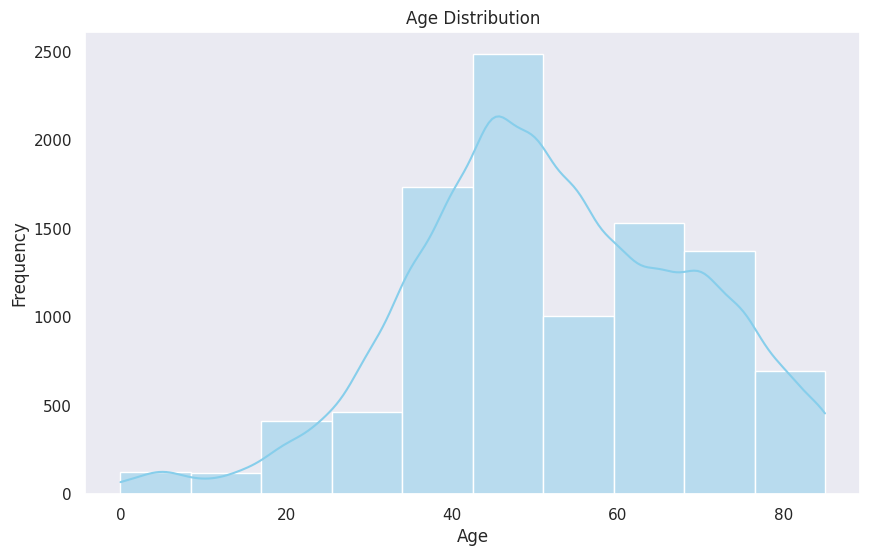

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(metadata['age'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

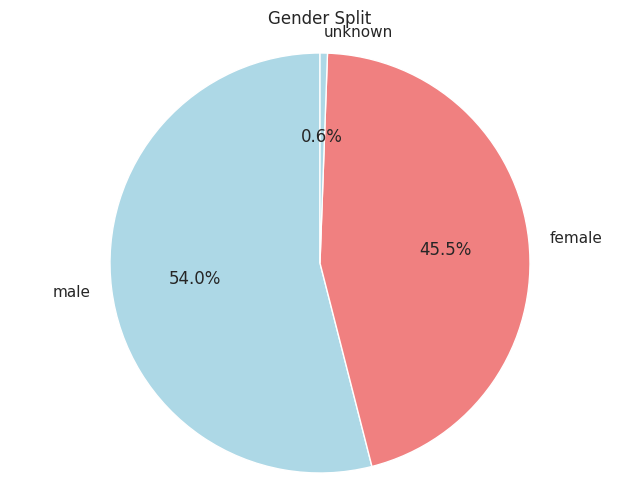

In [ ]:
# Count instances of each gender
gender_counts = metadata['sex'].value_counts()

# Plot the gender split
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Gender Split')
plt.axis('equal') 
plt.show()

In [ ]:
### Link the pictures and metadata

In [ ]:
# List all folders in the Labeled Data directory
image_directory = '/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/Skin Cancer Dataset/Skin Cancer Dataset/Labeled Data'
folders = os.listdir(image_directory)
print(files)

['HAM10000_metadata.csv', 'Skin Cancer Dataset']


In [ ]:
print(metadata.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [ ]:
# Convert the columns to strings
metadata['image_id'] = metadata['image_id'].astype(str)
metadata['dx'] = metadata['dx'].astype(str)

for index, row in metadata.iterrows():
    dx = row['dx'] 
    image_id = row['image_id'] + '.jpg' 
    folder_path = os.path.join(image_directory, dx)
    image_path = os.path.join(folder_path, image_id)
    # if os.path.exists(image_path):
    #     print(f"Image found: {image_path}")
    # else:
    #     print(f"Image not found for: {image_id} + {image_path}")


In [ ]:
def select_random_images(metadata, image_directory, n_samples=5):
    selected_images = {}
    dx_folders = metadata['dx'].unique()

    for dx in dx_folders:
        dx_metadata = metadata[metadata['dx'] == dx]
        
        num_images_to_sample = min(n_samples, len(dx_metadata)) 
        random_samples = dx_metadata.sample(n=num_images_to_sample, random_state=42)
        
        image_paths = []
        for index, row in random_samples.iterrows():
            image_id = row['image_id'] + '.jpg'  
            folder_path = os.path.join(image_directory, dx)
            image_path = os.path.join(folder_path, image_id)
            if os.path.exists(image_path):
                image_paths.append(image_path)

        selected_images[dx] = image_paths
    
    return selected_images

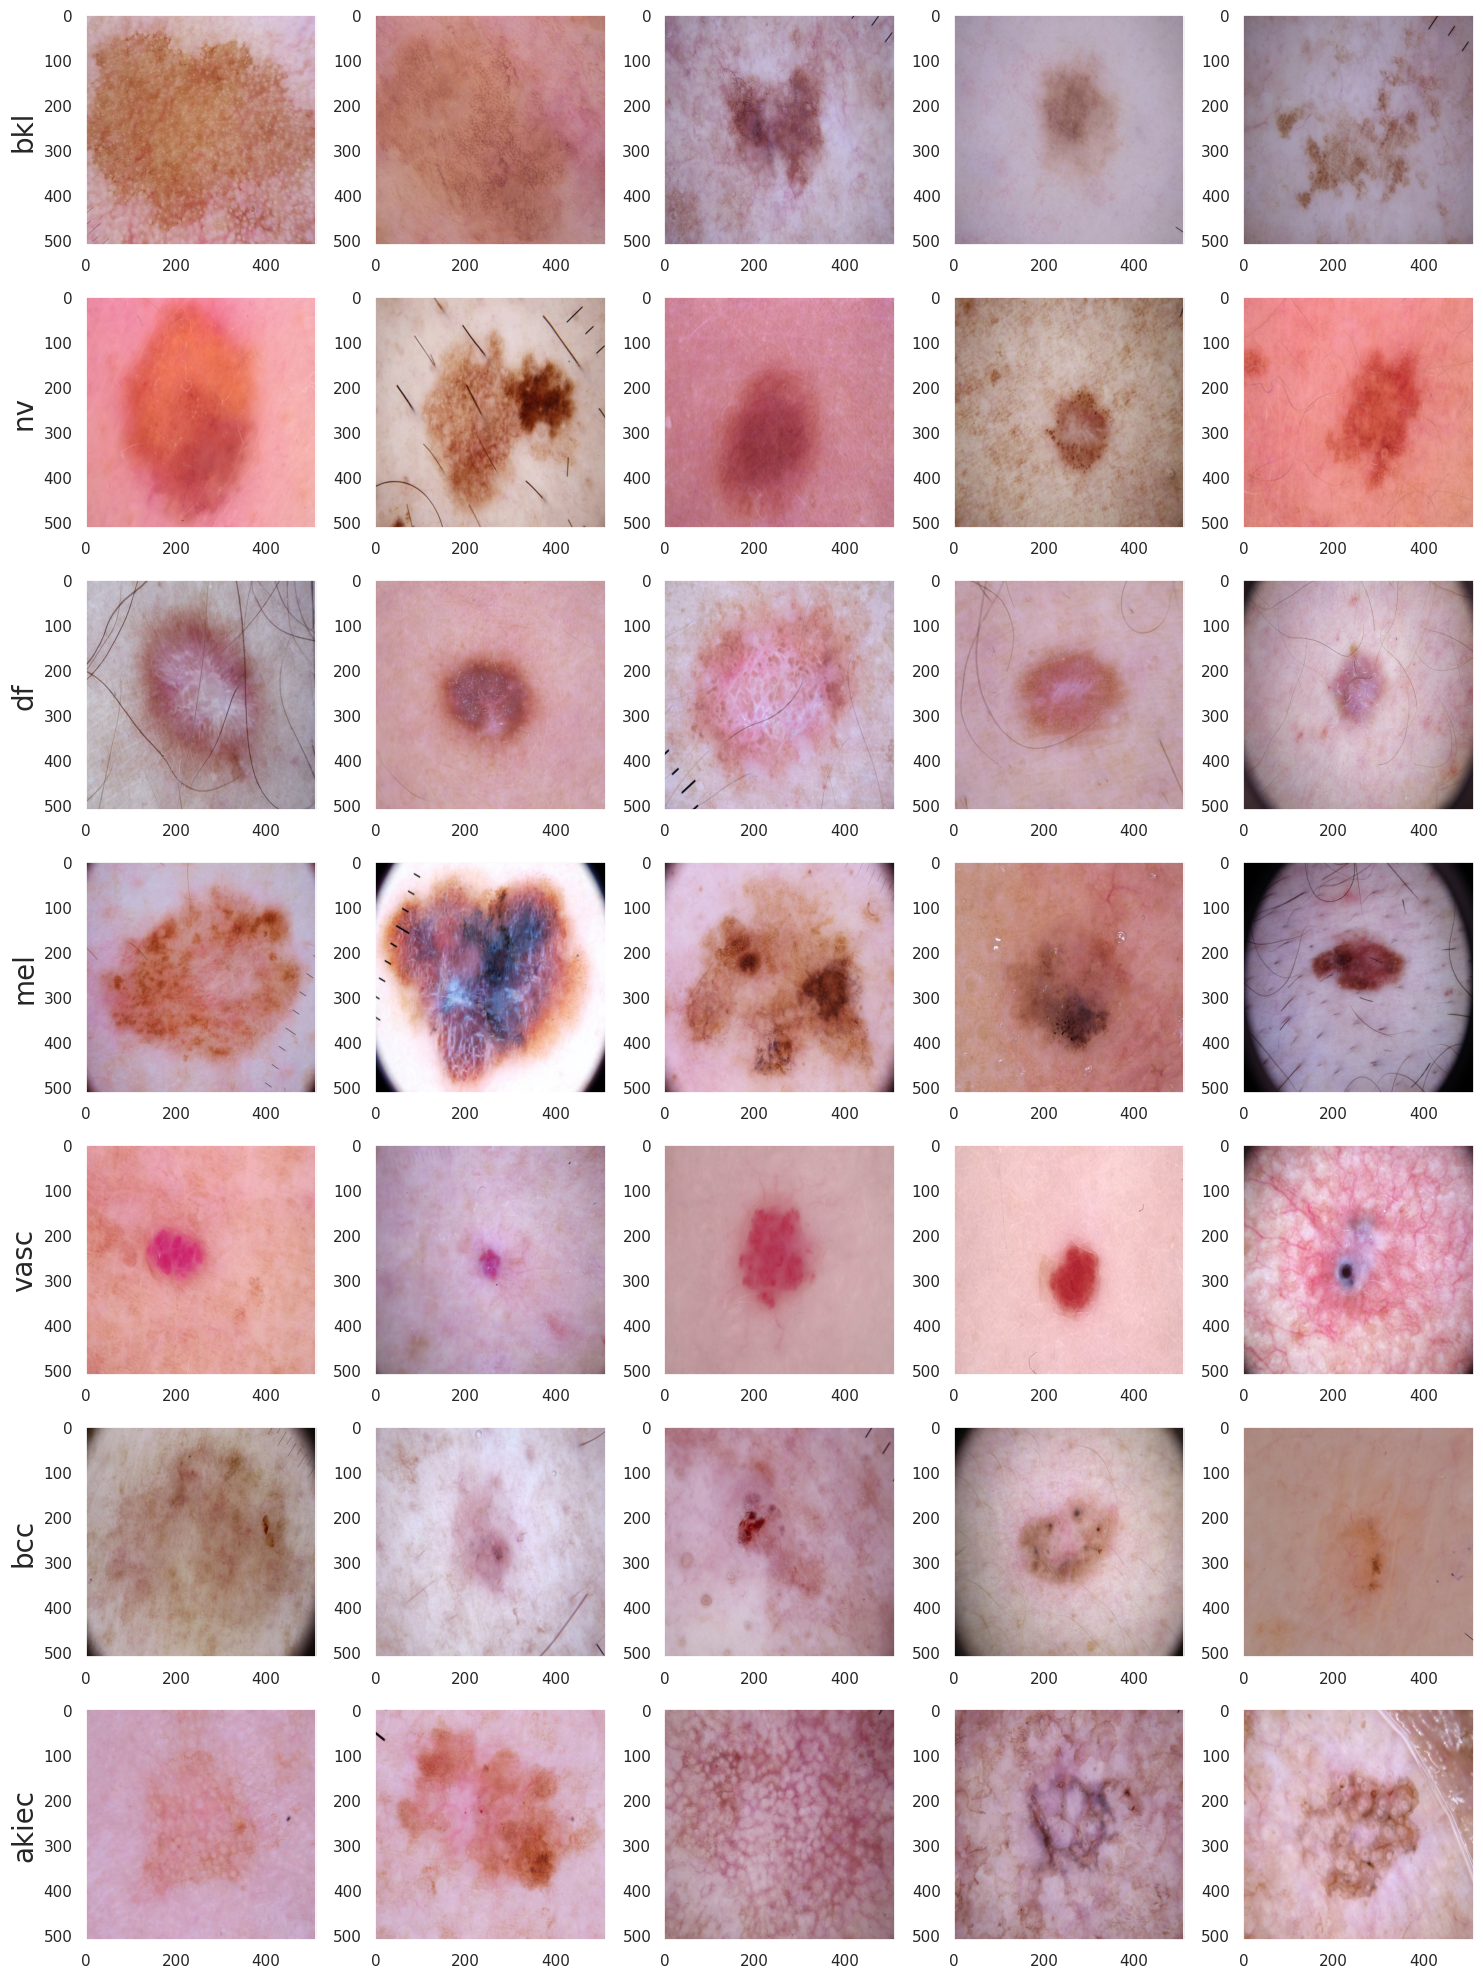

In [ ]:
def plot_images(selected_images):
    n_rows = len(selected_images)  
    n_cols = max(len(images) for images in selected_images.values()) 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

    for row_idx, (dx, image_paths) in enumerate(selected_images.items()):
        for col_idx, image_path in enumerate(image_paths):
            img = Image.open(image_path)
            axes[row_idx, col_idx].imshow(img)
            axes[row_idx, col_idx].axis('on')
            axes[row_idx, col_idx].grid(False)

        for col_idx in range(len(image_paths), n_cols):
            axes[row_idx, col_idx].axis('off')

    for row_idx, dx in enumerate(selected_images.keys()):
        axes[row_idx, 0].set_ylabel(dx, fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


selected_images = select_random_images(metadata, image_directory, n_samples=5)
plot_images(selected_images)

## Splittind dataset for training, validation and testing

In [ ]:
metadata = pd.read_csv('/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/HAM10000_metadata.csv')
image_directory = '/home/jovyan/.cache/kagglehub/datasets/rauf41/skin-cancer-image-dataset/versions/1/Skin Cancer Dataset/Skin Cancer Dataset/Labeled Data'

def link_images_to_metadata(metadata, image_directory):
    metadata['image_path'] = None

    for index, row in metadata.iterrows():
        dx = row['dx']
        image_id = row['image_id'] + '.jpg' 
        folder_path = os.path.join(image_directory, dx)
        image_path = os.path.join(folder_path, image_id)
        
        if os.path.exists(image_path):
            metadata.at[index, 'image_path'] = image_path

    return metadata

linked_metadata = link_images_to_metadata(metadata, image_directory)
linked_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/jovyan/.cache/kagglehub/datasets/rauf41/...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/jovyan/.cache/kagglehub/datasets/rauf41/...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/jovyan/.cache/kagglehub/datasets/rauf41/...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/jovyan/.cache/kagglehub/datasets/rauf41/...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/jovyan/.cache/kagglehub/datasets/rauf41/...


In [ ]:
train_df, temp_df = train_test_split(linked_metadata, test_size=0.3, random_state=42, stratify=linked_metadata['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['dx'])

# Display the sizes of the datasets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Save the datasets to CSV files
train_df.to_csv('train_metadata.csv', index=False)
val_df.to_csv('val_metadata.csv', index=False)
test_df.to_csv('test_metadata.csv', index=False)

Training set size: 7010
Validation set size: 1502
Test set size: 1503


In [ ]:
# Load the datasets
train_df = pd.read_csv('train_metadata.csv')
val_df = pd.read_csv('val_metadata.csv')
test_df = pd.read_csv('test_metadata.csv')


Resize the images and normalize pixel values to prepare them for training.

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128)) 
    img = img / 255.0  
    return img


X_train = np.array([preprocess_image(img_path) for img_path in train_df['image_path']])
y_train = train_df['dx'].values

X_val = np.array([preprocess_image(img_path) for img_path in val_df['image_path']])
y_val = val_df['dx'].values

X_test = np.array([preprocess_image(img_path) for img_path in test_df['image_path']])
y_test = test_df['dx'].values

In [ ]:
# Function to display a few images
def display_images(images, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')  # Hide axis
        plt.title(f"Image {i + 1}")
    plt.show()

# Displaying the first 5 processed images from the training set
display_images(X_train, n=5)